## 1. Imports, data load, and quick check

In [1]:
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import word_tokenize
from gensim.models import Word2Vec as w2v
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
import re
import tensorflow as tf
from tensorflow import keras
import string
from nltk.stem import PorterStemmer

2023-01-24 22:44:12.341237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('train.csv')

In [3]:
df

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
20967,20968,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1,1,0,0,0,0
20968,20969,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,0,1,0,0,0,0
20969,20970,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,1,0,0,0,0,0
20970,20971,On the Efficient Simulation of the Left-Tail o...,The sum of Log-normal variates is encountere...,0,0,1,1,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20972 non-null  int64 
 1   TITLE                 20972 non-null  object
 2   ABSTRACT              20972 non-null  object
 3   Computer Science      20972 non-null  int64 
 4   Physics               20972 non-null  int64 
 5   Mathematics           20972 non-null  int64 
 6   Statistics            20972 non-null  int64 
 7   Quantitative Biology  20972 non-null  int64 
 8   Quantitative Finance  20972 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.4+ MB


## 2. Numerical analysis

## 2.1. Subject proportions and papers with multiple tags

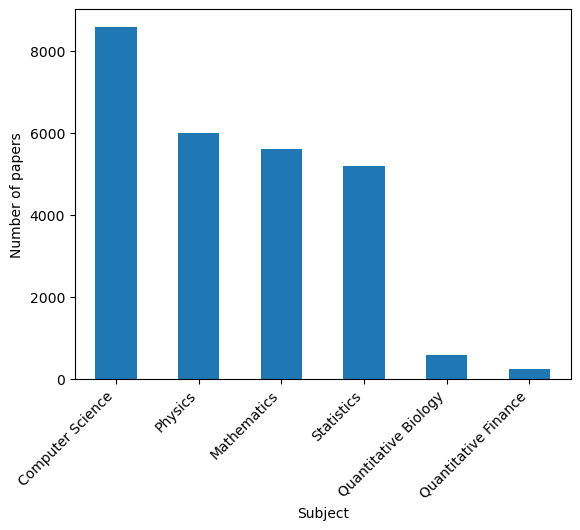

In [5]:
#Check number of papers for each subject
df[['Computer Science', 'Physics', 'Mathematics', 'Statistics',
   'Quantitative Biology', 'Quantitative Finance']].sum().plot.bar()
plt.xlabel('Subject')
plt.ylabel('Number of papers')
plt.xticks(rotation=45, ha='right')
plt.show()

In [6]:
#Find number of tags for each paper and visualize them
df['Number_of_tags'] = df['Computer Science'] + df['Physics']+\
df['Mathematics'] +df['Statistics'] + df['Quantitative Biology'] +\
df['Quantitative Finance']

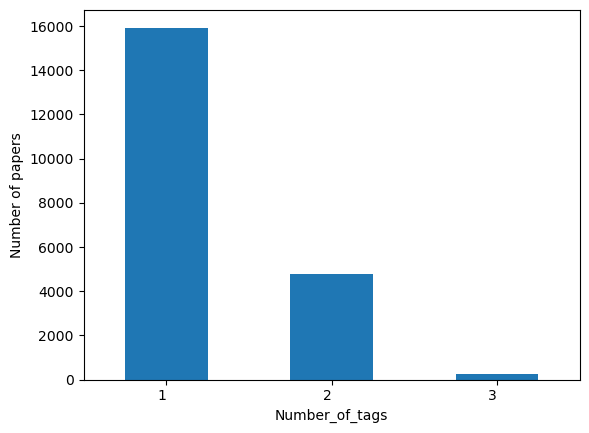

In [7]:
df['Number_of_tags'].value_counts().plot.bar()
plt.xlabel('Number_of_tags')
plt.ylabel('Number of papers')
plt.xticks(rotation=0, ha='right')
plt.show()

In [8]:
# Visualize the numbers of papers of three tags for each subject
df_3_tags = df[df.Number_of_tags == 3]
df_3_tags_ratio = 100*df_3_tags[['Computer Science', 'Physics', 'Mathematics', 'Statistics',
   'Quantitative Biology', 'Quantitative Finance']].sum()/df[['Computer Science', 'Physics', 
                                                              'Mathematics', 'Statistics',
   'Quantitative Biology', 'Quantitative Finance']].sum()

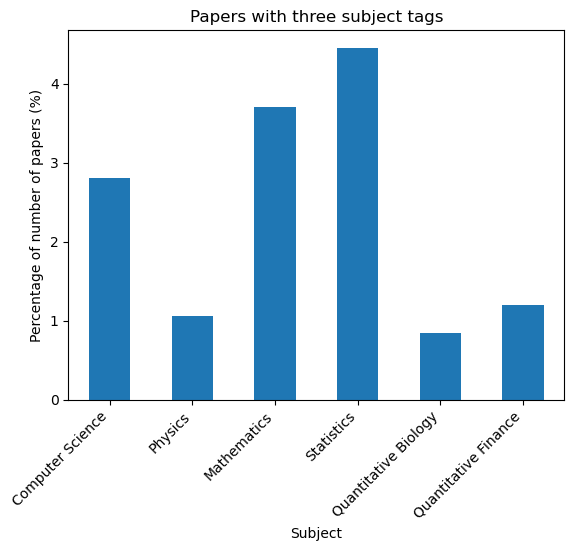

In [9]:
df_3_tags_ratio.plot.bar()
plt.xlabel('Subject')
plt.ylabel('Percentage of number of papers (%)')
plt.xticks(rotation=45, ha='right')
plt.title('Papers with three subject tags')
plt.show()

In [10]:
# Visualize the numbers of papers of two tags for each subject
df_2_tags = df[df.Number_of_tags == 2]
df_2_tags_ratio = 100*df_2_tags[['Computer Science', 'Physics', 'Mathematics', 'Statistics',
   'Quantitative Biology', 'Quantitative Finance']].sum()/df[['Computer Science', 'Physics', 
                                                              'Mathematics', 'Statistics',
   'Quantitative Biology', 'Quantitative Finance']].sum()

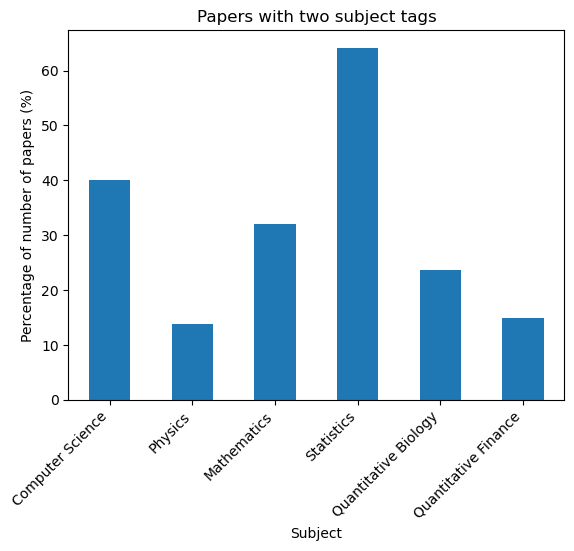

In [11]:
df_2_tags_ratio.plot.bar()
plt.xlabel('Subject')
plt.ylabel('Percentage of number of papers (%)')
plt.xticks(rotation=45, ha='right')
plt.title('Papers with two subject tags')
plt.show()

In [12]:
# Visualize the numbers papers of only one tags for each subject
df_1_tags = df[df.Number_of_tags == 1]
df_1_tags_ratio = 100*df_1_tags[['Computer Science', 'Physics', 'Mathematics', 'Statistics',
   'Quantitative Biology', 'Quantitative Finance']].sum()/df[['Computer Science', 'Physics', 
                                                              'Mathematics', 'Statistics',
   'Quantitative Biology', 'Quantitative Finance']].sum()

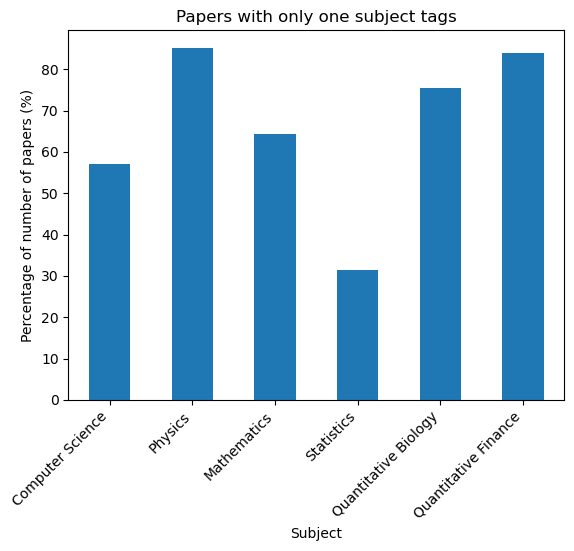

In [13]:
df_1_tags_ratio.plot.bar()
plt.xlabel('Subject')
plt.ylabel('Percentage of number of papers (%)')
plt.xticks(rotation=45, ha='right')
plt.title('Papers with only one subject tags')
plt.show()

## 2.2. Title lengths and abstract lengths

## 2.2.1. Outliers removal

In [14]:
# Find the title length of each paper and remove title length outliers
df['length_of_title'] = df['TITLE'].str.split().apply(lambda x: len(x))

In [15]:
df['length_of_title'].value_counts().sort_index()

1        6
2      108
3      373
4      605
5     1252
6     1826
7     2393
8     2377
9     2429
10    2326
11    1903
12    1499
13    1155
14     857
15     625
16     388
17     259
18     221
19     147
20      82
21      47
22      21
23      19
24      11
25      13
26       5
27       8
28       4
29       3
30       2
31       3
32       1
33       1
36       1
38       1
40       1
Name: length_of_title, dtype: int64

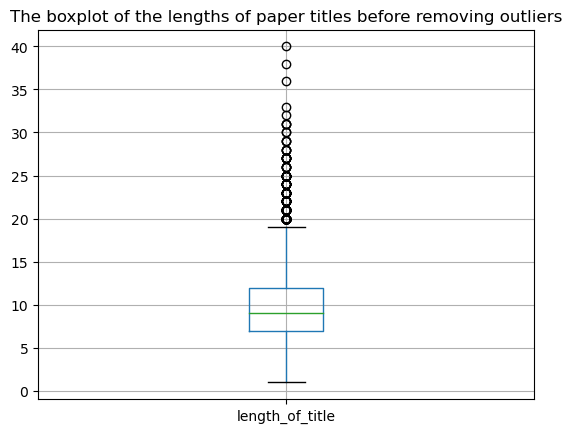

In [16]:
df[['length_of_title']].boxplot()
plt.title('The boxplot of the lengths of paper titles before removing outliers')
plt.show()

In [17]:
len(df[df['length_of_title'] >= 18])/len(df)

0.028180431050925044

In [18]:
df = df[df['length_of_title'] < 18]

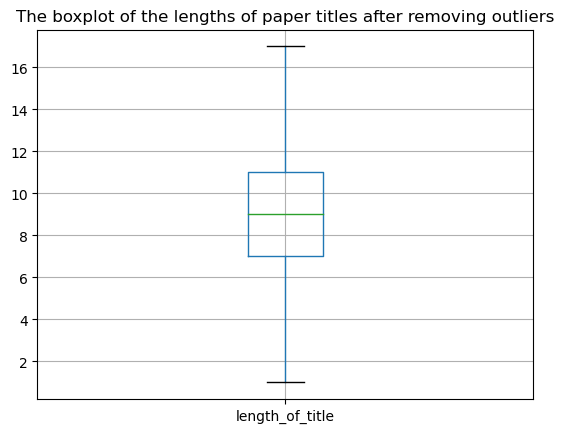

In [19]:
df[['length_of_title']].boxplot()
plt.title('The boxplot of the lengths of paper titles after removing outliers')
plt.show()

In [20]:
# Find the abstract length of each paper and remove abtract length outliers
df['length_of_abstract'] = df['ABSTRACT'].str.split().apply(lambda x: len(x))

/var/folders/2d/q596lzpj3gs9lx0bnt_wn55m0000gn/T/ipykernel_4103/1334950275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['length_of_abstract'] = df['ABSTRACT'].str.split().apply(lambda x: len(x))


In [21]:
df['length_of_abstract'].value_counts().sort_index()

1      1
6      1
8      1
9      1
10     2
      ..
325    1
328    1
354    1
419    1
449    1
Name: length_of_abstract, Length: 319, dtype: int64

In [22]:
df.columns

Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance',
       'Number_of_tags', 'length_of_title', 'length_of_abstract'],
      dtype='object')

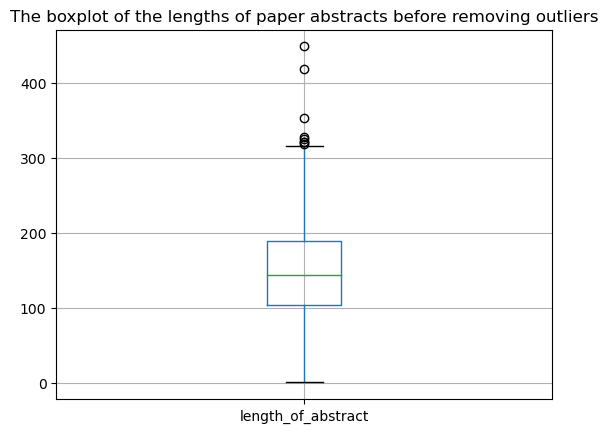

In [23]:
df[['length_of_abstract']].boxplot()
plt.title('The boxplot of the lengths of paper abstracts before removing outliers')
plt.show()

In [24]:
len(df[df['length_of_abstract'] >= 309])/len(df)

0.001373828565821108

In [25]:
df = df[df['length_of_abstract'] < 309]

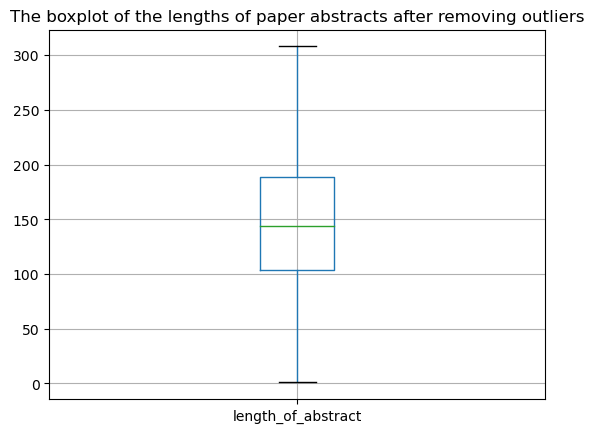

In [26]:
df[['length_of_abstract']].boxplot()
plt.title('The boxplot of the lengths of paper abstracts after removing outliers')
plt.show()

## 2.2.2 Title length and abstract length on each subject

In [27]:
df_CS = df.loc[df['Computer Science'] == 1]
df_P = df[df['Physics'] == 1]
df_M = df[df['Mathematics'] == 1]
df_S = df[df['Statistics'] == 1]
df_QB = df[df['Quantitative Biology'] == 1]
df_QF = df[df['Quantitative Finance'] == 1]

In [28]:
df.columns

Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance',
       'Number_of_tags', 'length_of_title', 'length_of_abstract'],
      dtype='object')

In [29]:
df_CS.columns

Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance',
       'Number_of_tags', 'length_of_title', 'length_of_abstract'],
      dtype='object')

In [30]:
df_CS['length_of_title']

0         4
1         4
10       12
13        5
22        8
         ..
20963     9
20964    12
20966    10
20967    11
20969     7
Name: length_of_title, Length: 8442, dtype: int64

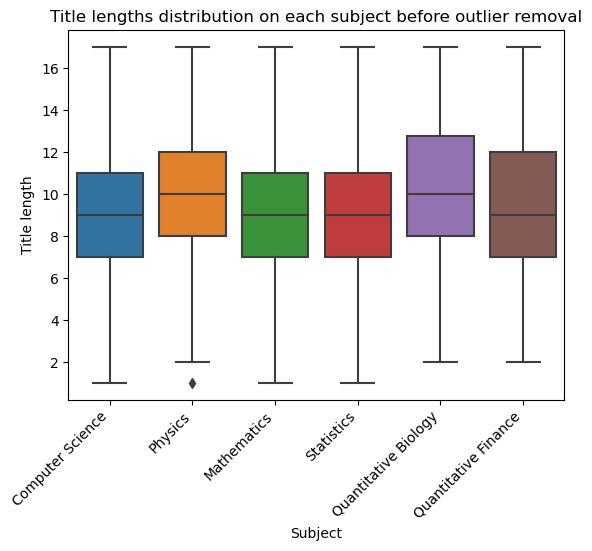

In [31]:
sns.boxplot(data = [df_CS['length_of_title'], df_P['length_of_title'], df_M['length_of_title'],
                   df_S['length_of_title'], df_QB['length_of_title'], df_QF['length_of_title']], orient="v")
plt.xlabel('Subject')
plt.ylabel('Title length')
labels = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 
                    'Quantitative Finance']
plt.xticks([0, 1, 2, 3, 4, 5], labels, rotation=45, ha='right')
plt.title('Title lengths distribution on each subject before outlier removal')
plt.show()

In [32]:
df[(df['Physics'] == 1) & (df['length_of_title'] == 1)]

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,Number_of_tags,length_of_title,length_of_abstract
9988,9989,Hyperinflation,A model of cosmological inflation is propose...,0,1,0,0,0,0,1,1,78


In [33]:
df[df['Physics'] == 1] = df_P[df_P['length_of_title'] != 1]
df_P = df[df['Physics'] == 1]

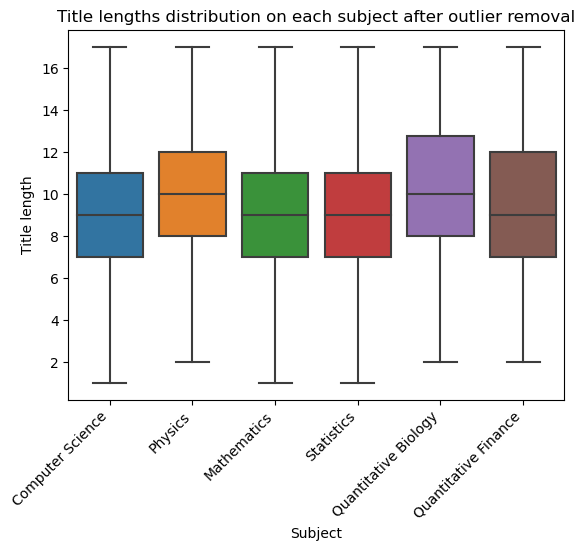

In [34]:
sns.boxplot(data = [df_CS['length_of_title'], df_P['length_of_title'], df_M['length_of_title'],
                   df_S['length_of_title'], df_QB['length_of_title'], df_QF['length_of_title']], orient="v")
plt.xlabel('Subject')
plt.ylabel('Title length')
labels = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 
                    'Quantitative Finance']
plt.xticks([0, 1, 2, 3, 4, 5], labels, rotation=45, ha='right')
plt.title('Title lengths distribution on each subject after outlier removal')
plt.show()

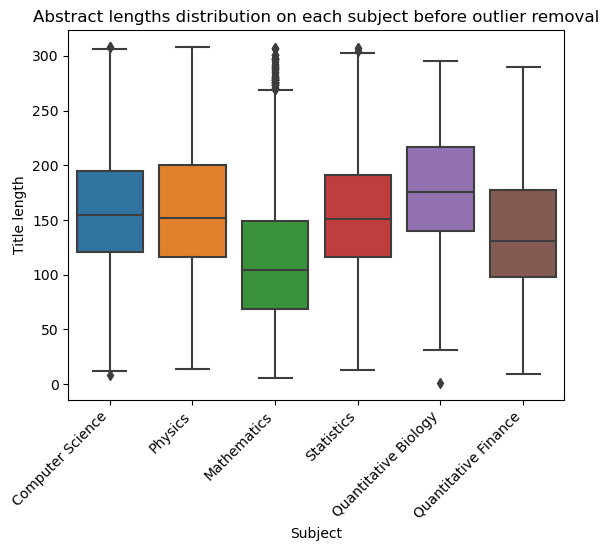

In [35]:
sns.boxplot(data = [df_CS['length_of_abstract'], df_P['length_of_abstract'], df_M['length_of_abstract'],
                   df_S['length_of_abstract'], df_QB['length_of_abstract'], df_QF['length_of_abstract']], orient="v")
plt.xlabel('Subject')
plt.ylabel('Title length')
labels = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 
                    'Quantitative Finance']
plt.title('Abstract lengths distribution on each subject before outlier removal')
plt.xticks([0, 1, 2, 3, 4, 5], labels, rotation=45, ha='right')
plt.show()

In [36]:
len(df_M[df_M.length_of_abstract > 260])/len(df)

0.005011546209404019

In [37]:
df[df['Mathematics'] == 1] = df_M[df_M['length_of_abstract'] <=260]
df_M = df[df['Mathematics'] == 1]

In [38]:
len(df_CS[(df_CS.length_of_abstract < 10) | (df_CS.length_of_abstract > 306)])/len(df)

0.00014739841792364762

In [39]:
df[df['Computer Science'] == 1] = df_CS[(df_CS['length_of_abstract'] <=306) & (df_CS['length_of_abstract'] >=10)]
df_CS = df[df['Computer Science'] == 1]

In [40]:
len(df_S[df_S.length_of_abstract > 300])/len(df)

0.00029479683584729524

In [41]:
df[df['Statistics'] == 1] = df_S[df_S['length_of_abstract'] <=300]
df_S = df[df['Statistics'] == 1]

In [42]:
len(df_QB[(df_QB.length_of_abstract < 30)])/len(df)

4.913280597454921e-05

In [43]:
df[df['Quantitative Biology'] == 1] = df_QB[df_QB['length_of_abstract'] >=30]
df_QB = df[df['Quantitative Biology'] == 1]

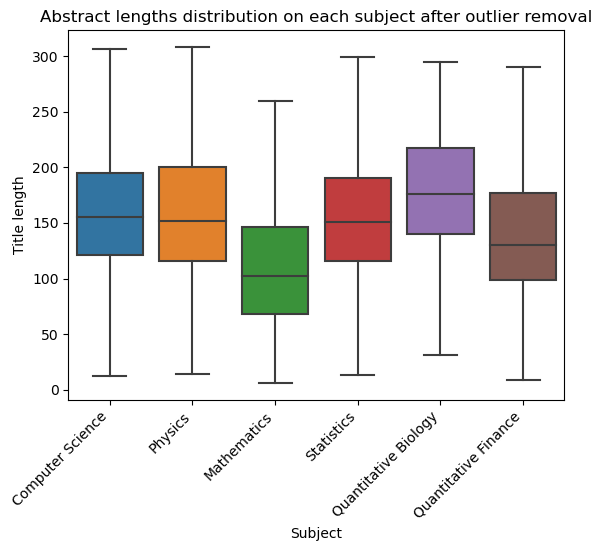

In [44]:
sns.boxplot(data = [df_CS['length_of_abstract'], df_P['length_of_abstract'], df_M['length_of_abstract'],
                   df_S['length_of_abstract'], df_QB['length_of_abstract'], df_QF['length_of_abstract']], orient="v")
plt.xlabel('Subject')
plt.ylabel('Title length')
labels = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 
                    'Quantitative Finance']
plt.title('Abstract lengths distribution on each subject after outlier removal')
plt.xticks([0, 1, 2, 3, 4, 5], labels, rotation=45, ha='right')
plt.show()

In [45]:
df

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,Number_of_tags,length_of_title,length_of_abstract
0,1.0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,265.0
1,2.0,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,76.0
2,3.0,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,8.0,99.0
3,4.0,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,110.0
5,6.0,On maximizing the fundamental frequency of the...,Let $\Omega \subset \mathbb{R}^n$ be a bound...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,11.0,210.0
...,...,...,...,...,...,...,...,...,...,...,...,...
20967,20968.0,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1.0,1.0,0.0,0.0,0.0,0.0,2.0,11.0,194.0
20968,20969.0,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,15.0,134.0
20969,20970.0,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,194.0
20970,20971.0,On the Efficient Simulation of the Left-Tail o...,The sum of Log-normal variates is encountere...,0.0,0.0,1.0,1.0,0.0,0.0,2.0,14.0,193.0


## 3. Text Cleaning and Analysis

In [46]:
def basic_text_cleaning(text):
    text = text.str.replace('\n', ' ')
    text = text.str.replace('\r', ' ')
    text = text.str.replace('\t', ' ')
    text = text.apply(lambda x: re.sub(r'[0-9]','',str(x)))
    text = text.apply(lambda x: re.sub(r'[/(){}\[\]\|@,;.:-]',' ',str(x)))
    text = text.str.replace('  ',' ')
    return text

In [47]:
df['TITLE'] = basic_text_cleaning(df['TITLE'])
df['ABSTRACT'] = basic_text_cleaning(df['ABSTRACT'])

In [48]:
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

def tokenize(text):
    split=re.split("\W+",text) 
    return split

def remove_stopwords(text):
    stopword = nltk.corpus.stopwords.words('english')
    text=[word for word in text if word not in stopword]
    return text

def stemmized(text):
    ps = PorterStemmer()
    text=[ps.stem(word) for word in text]
    return text

In [49]:
def more_text_cleaning(text):
    text = text.apply(lambda x: remove_punctuation(x))
    text = text.apply(lambda x: tokenize(x.lower()))
    text = text.apply(lambda x: remove_stopwords(x))
    text = text.apply(lambda x: stemmized(x))
    text = text.apply(lambda x: ' '.join(x))
    return text

In [50]:
df['TITLE'] = more_text_cleaning(df['TITLE'])
df['ABSTRACT'] = more_text_cleaning(df['ABSTRACT'])

In [51]:
df

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,Number_of_tags,length_of_title,length_of_abstract
0,1.0,reconstruct subject specif effect map,predict model allow subject specif infer anal...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,265.0
1,2.0,rotat invari neural network,rotat invari translat invari great valu imag ...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,76.0
2,3.0,spheric polyharmon poisson kernel polyharmon f...,introduc develop notion spheric polyharmon na...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,8.0,99.0
3,4.0,finit element approxim stochast maxwel landau ...,stochast landau lifshitz gilbert llg equat co...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,110.0
5,6.0,maxim fundament frequenc complement obstacl,let omega subset mathbb r n bound domain sati...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,11.0,210.0
...,...,...,...,...,...,...,...,...,...,...,...,...
20967,20968.0,contemporari machin learn guid practition phys...,machin learn find increasingli broad applic p...,1.0,1.0,0.0,0.0,0.0,0.0,2.0,11.0,194.0
20968,20969.0,uniform diamond coat wc co hard alloy cut inse...,polycrystallin diamond coat grown cement carb...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,15.0,134.0
20969,20970.0,analys soccer game cluster conceptor,present new approach identifi situat behaviou...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,194.0
20970,20971.0,effici simul left tail sum correl log normal v...,sum log normal variat encount mani challeng a...,0.0,0.0,1.0,1.0,0.0,0.0,2.0,14.0,193.0


## 4. Final Check and Converting to CSV file

In [52]:
df

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,Number_of_tags,length_of_title,length_of_abstract
0,1.0,reconstruct subject specif effect map,predict model allow subject specif infer anal...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,265.0
1,2.0,rotat invari neural network,rotat invari translat invari great valu imag ...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,76.0
2,3.0,spheric polyharmon poisson kernel polyharmon f...,introduc develop notion spheric polyharmon na...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,8.0,99.0
3,4.0,finit element approxim stochast maxwel landau ...,stochast landau lifshitz gilbert llg equat co...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,110.0
5,6.0,maxim fundament frequenc complement obstacl,let omega subset mathbb r n bound domain sati...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,11.0,210.0
...,...,...,...,...,...,...,...,...,...,...,...,...
20967,20968.0,contemporari machin learn guid practition phys...,machin learn find increasingli broad applic p...,1.0,1.0,0.0,0.0,0.0,0.0,2.0,11.0,194.0
20968,20969.0,uniform diamond coat wc co hard alloy cut inse...,polycrystallin diamond coat grown cement carb...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,15.0,134.0
20969,20970.0,analys soccer game cluster conceptor,present new approach identifi situat behaviou...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,194.0
20970,20971.0,effici simul left tail sum correl log normal v...,sum log normal variat encount mani challeng a...,0.0,0.0,1.0,1.0,0.0,0.0,2.0,14.0,193.0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20353 entries, 0 to 20971
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    20243 non-null  float64
 1   TITLE                 20353 non-null  object 
 2   ABSTRACT              20353 non-null  object 
 3   Computer Science      20243 non-null  float64
 4   Physics               20243 non-null  float64
 5   Mathematics           20243 non-null  float64
 6   Statistics            20243 non-null  float64
 7   Quantitative Biology  20243 non-null  float64
 8   Quantitative Finance  20243 non-null  float64
 9   Number_of_tags        20243 non-null  float64
 10  length_of_title       20243 non-null  float64
 11  length_of_abstract    20243 non-null  float64
dtypes: float64(10), object(2)
memory usage: 2.0+ MB


In [54]:
df.dropna(inplace = True)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20243 entries, 0 to 20971
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    20243 non-null  float64
 1   TITLE                 20243 non-null  object 
 2   ABSTRACT              20243 non-null  object 
 3   Computer Science      20243 non-null  float64
 4   Physics               20243 non-null  float64
 5   Mathematics           20243 non-null  float64
 6   Statistics            20243 non-null  float64
 7   Quantitative Biology  20243 non-null  float64
 8   Quantitative Finance  20243 non-null  float64
 9   Number_of_tags        20243 non-null  float64
 10  length_of_title       20243 non-null  float64
 11  length_of_abstract    20243 non-null  float64
dtypes: float64(10), object(2)
memory usage: 2.0+ MB


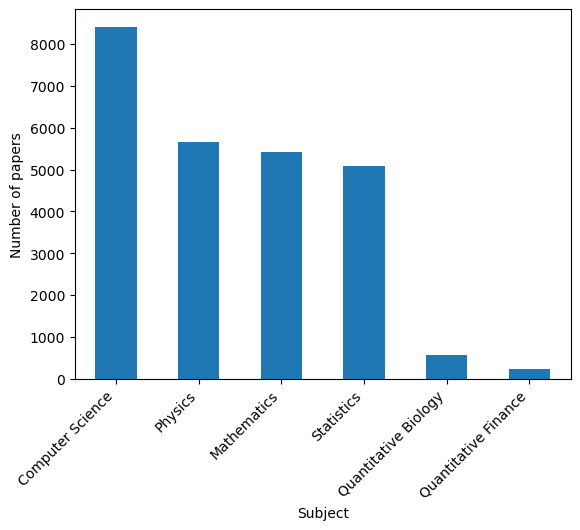

In [56]:
df[['Computer Science', 'Physics', 'Mathematics', 'Statistics',
   'Quantitative Biology', 'Quantitative Finance']].sum().plot.bar()
plt.xlabel('Subject')
plt.ylabel('Number of papers')
plt.xticks(rotation=45, ha='right')
plt.show()

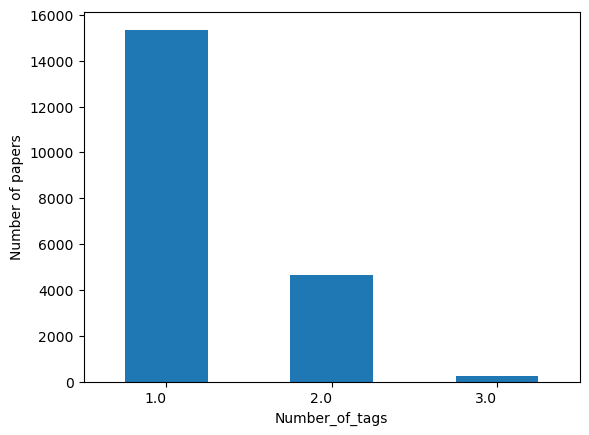

In [57]:
df['Number_of_tags'].value_counts().plot.bar()
plt.xlabel('Number_of_tags')
plt.ylabel('Number of papers')
plt.xticks(rotation=0, ha='right')
plt.show()

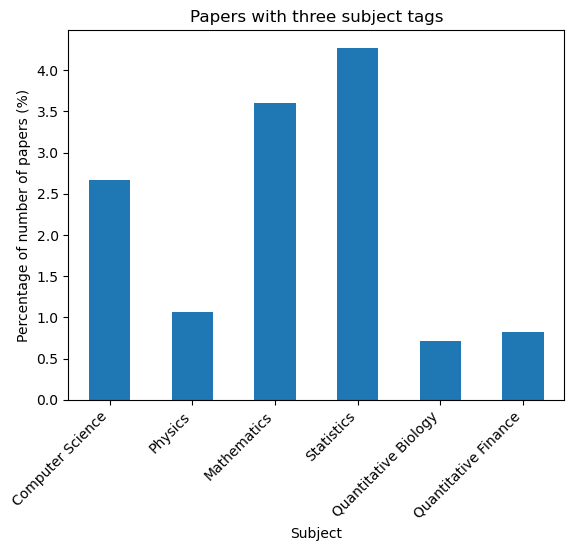

In [58]:
df_3_tags = df[df.Number_of_tags == 3]
df_3_tags_ratio = 100*df_3_tags[['Computer Science', 'Physics', 'Mathematics', 'Statistics',
   'Quantitative Biology', 'Quantitative Finance']].sum()/df[['Computer Science', 'Physics', 
                                                              'Mathematics', 'Statistics',
   'Quantitative Biology', 'Quantitative Finance']].sum()

df_3_tags_ratio.plot.bar()
plt.xlabel('Subject')
plt.ylabel('Percentage of number of papers (%)')
plt.xticks(rotation=45, ha='right')
plt.title('Papers with three subject tags')
plt.show()

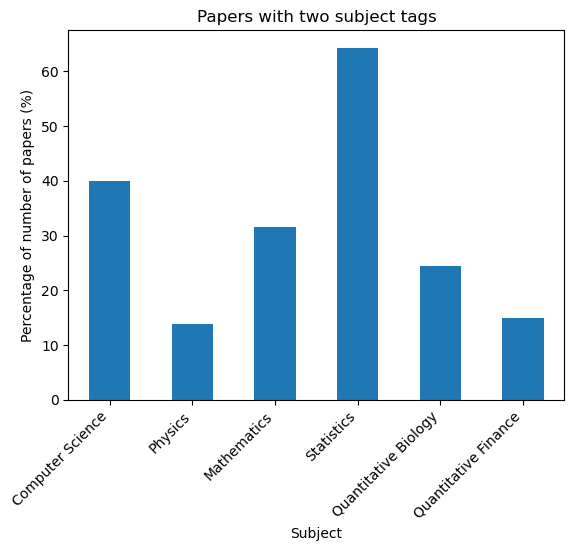

In [59]:
df_2_tags = df[df.Number_of_tags == 2]
df_2_tags_ratio = 100*df_2_tags[['Computer Science', 'Physics', 'Mathematics', 'Statistics',
   'Quantitative Biology', 'Quantitative Finance']].sum()/df[['Computer Science', 'Physics', 
                                                              'Mathematics', 'Statistics',
   'Quantitative Biology', 'Quantitative Finance']].sum()

df_2_tags_ratio.plot.bar()
plt.xlabel('Subject')
plt.ylabel('Percentage of number of papers (%)')
plt.xticks(rotation=45, ha='right')
plt.title('Papers with two subject tags')
plt.show()

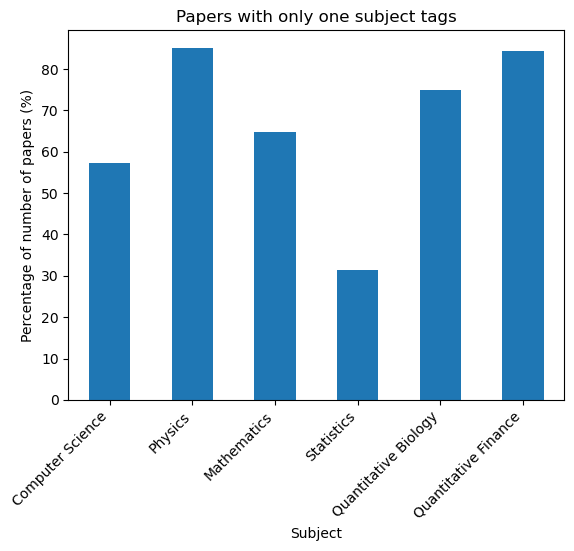

In [60]:
df_1_tags = df[df.Number_of_tags == 1]
df_1_tags_ratio = 100*df_1_tags[['Computer Science', 'Physics', 'Mathematics', 'Statistics',
   'Quantitative Biology', 'Quantitative Finance']].sum()/df[['Computer Science', 'Physics', 
                                                              'Mathematics', 'Statistics',
   'Quantitative Biology', 'Quantitative Finance']].sum()

df_1_tags_ratio.plot.bar()
plt.xlabel('Subject')
plt.ylabel('Percentage of number of papers (%)')
plt.xticks(rotation=45, ha='right')
plt.title('Papers with only one subject tags')
plt.show()

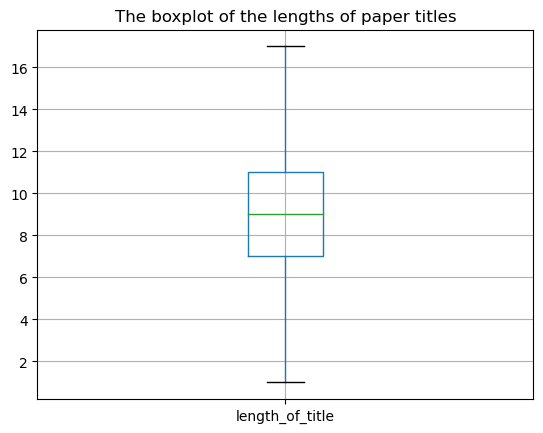

In [61]:
df[['length_of_title']].boxplot()
plt.title('The boxplot of the lengths of paper titles')
plt.show()

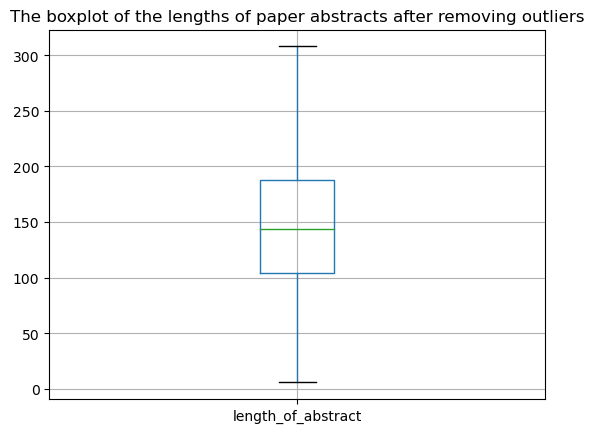

In [62]:
df[['length_of_abstract']].boxplot()
plt.title('The boxplot of the lengths of paper abstracts after removing outliers')
plt.show()

In [63]:
df_CS = df.loc[df['Computer Science'] == 1]
df_P = df[df['Physics'] == 1]
df_M = df[df['Mathematics'] == 1]
df_S = df[df['Statistics'] == 1]
df_QB = df[df['Quantitative Biology'] == 1]
df_QF = df[df['Quantitative Finance'] == 1]

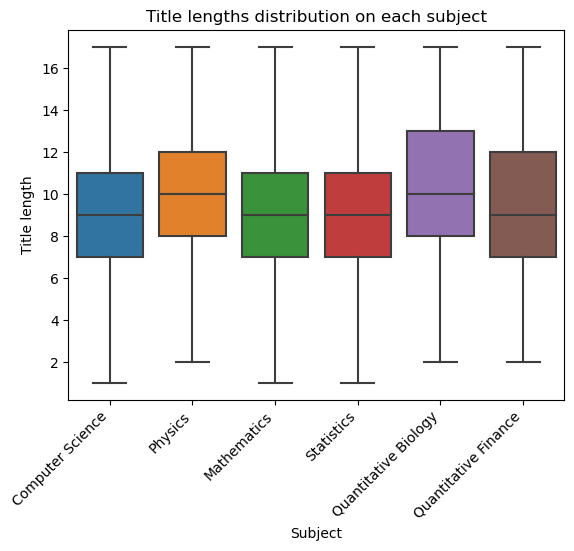

In [64]:
sns.boxplot(data = [df_CS['length_of_title'], df_P['length_of_title'], df_M['length_of_title'],
                   df_S['length_of_title'], df_QB['length_of_title'], df_QF['length_of_title']], orient="v")
plt.xlabel('Subject')
plt.ylabel('Title length')
labels = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 
                    'Quantitative Finance']
plt.xticks([0, 1, 2, 3, 4, 5], labels, rotation=45, ha='right')
plt.title('Title lengths distribution on each subject')
plt.show()

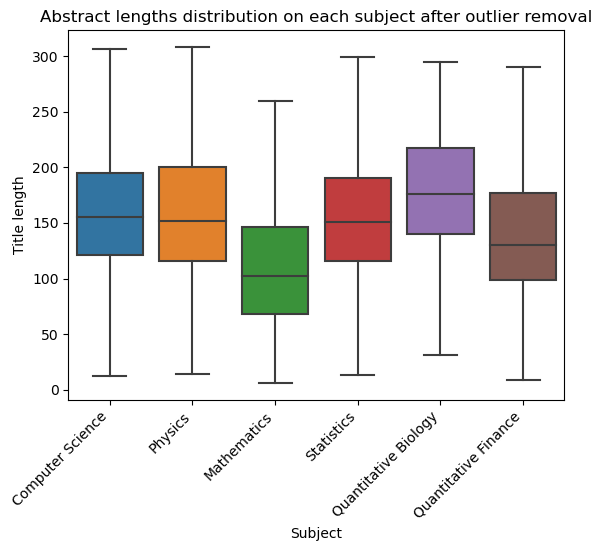

In [65]:
sns.boxplot(data = [df_CS['length_of_abstract'], df_P['length_of_abstract'], df_M['length_of_abstract'],
                   df_S['length_of_abstract'], df_QB['length_of_abstract'], df_QF['length_of_abstract']], orient="v")
plt.xlabel('Subject')
plt.ylabel('Title length')
labels = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 
                    'Quantitative Finance']
plt.title('Abstract lengths distribution on each subject after outlier removal')
plt.xticks([0, 1, 2, 3, 4, 5], labels, rotation=45, ha='right')
plt.show()

In [66]:
df.to_csv('Cleaned_Data.csv')